In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['cataract','diabetic_retinopathy','glaucoma','normal']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [6]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [8]:
# Setup directory paths to train and test images
train_dir = '/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Training'
test_dir = '/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [9]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [10]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=0,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [11]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [12]:
from goingmodular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6603 | train_acc: 0.7427 | test_loss: 0.5400 | test_acc: 0.7821
Epoch: 2 | train_loss: 0.4837 | train_acc: 0.8205 | test_loss: 0.4409 | test_acc: 0.8325
Epoch: 3 | train_loss: 0.4263 | train_acc: 0.8452 | test_loss: 0.3904 | test_acc: 0.8725
Epoch: 4 | train_loss: 0.3965 | train_acc: 0.8584 | test_loss: 0.3738 | test_acc: 0.8690
Epoch: 5 | train_loss: 0.3700 | train_acc: 0.8680 | test_loss: 0.3448 | test_acc: 0.8892
Epoch: 6 | train_loss: 0.3543 | train_acc: 0.8763 | test_loss: 0.3674 | test_acc: 0.8638
Epoch: 7 | train_loss: 0.3376 | train_acc: 0.8813 | test_loss: 0.3405 | test_acc: 0.8752
Epoch: 8 | train_loss: 0.3199 | train_acc: 0.8896 | test_loss: 0.3176 | test_acc: 0.8975
Epoch: 9 | train_loss: 0.3074 | train_acc: 0.8965 | test_loss: 0.2963 | test_acc: 0.9104
Epoch: 10 | train_loss: 0.2982 | train_acc: 0.8997 | test_loss: 0.2776 | test_acc: 0.9090
Epoch: 11 | train_loss: 0.2957 | train_acc: 0.9012 | test_loss: 0.3141 | test_acc: 0.8783
Epoch: 12 | train_l

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

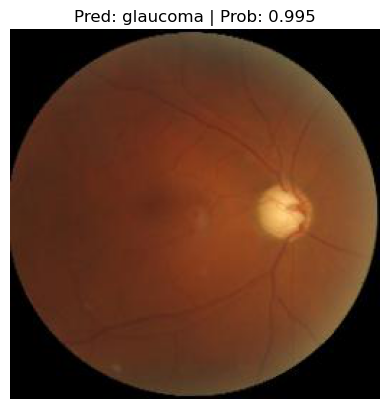

In [17]:
import requests

# Import function to make predictions on images and plot them 
from goingmodular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/glaucoma/_14_3746939.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

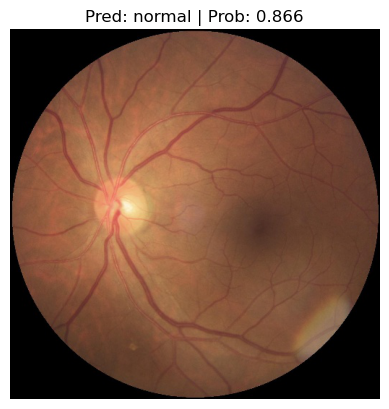

In [19]:
# Import function to make predictions on images and plot them 
from goingmodular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/normal/1034_left.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

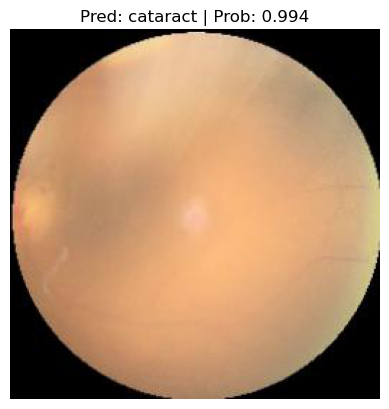

In [21]:
# Import function to make predictions on images and plot them 
from goingmodular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/cataract/_1_5346540.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)